In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures

#### Cargamos datos

In [13]:
datalab = pd.read_csv('train.csv')
datalab.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


In [14]:
datalab.shape
#vemos que hay 11 columnas con 14447 datos

(14447, 11)

#### 1. Columnas con faltantes

In [15]:
#A estas columnas tenemos que hacerle algún tipo de imputación
cols_NaN = [col for col in datalab.columns if(datalab[col].isnull().mean()>0)]
cols_NaN
#vemos que solo hay una columna con datos faltantes

['total_bedrooms']

In [16]:
# necesitamos conocer el tipo de datos de cada columna
# si son numeros, la imputacion se hace de una forma y si son string se hace de otra forma
datalab[cols_NaN].dtypes

total_bedrooms    float64
dtype: object

#### 2. Proporción de faltantes

In [17]:
#Buscamos el porcentaje de NaN que tienen cada columna
#Un 5% es el maximo para hacer imputacion, mas de eso no vale la pena.
prop_NaN = datalab[cols_NaN].isnull().mean()*100
prop_NaN
#La unica columna con NaN tiene un 0.94% de faltantes, es util para hacer imputacion

total_bedrooms    0.948294
dtype: float64

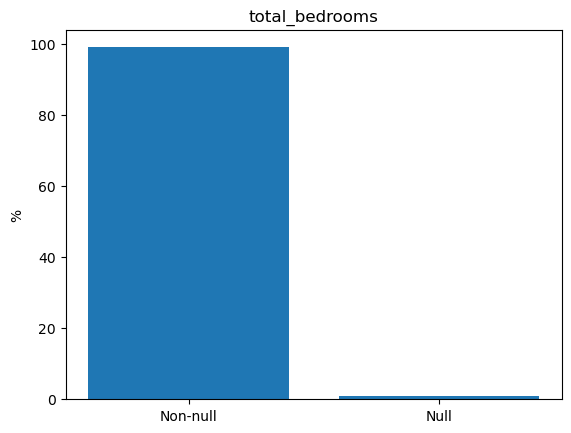

In [37]:
fig, ax = plt.subplots()
ax.bar(['Non-null', 'Null'], [(datalab['total_bedrooms'].count()/ len(datalab.index))*100, datalab['total_bedrooms'].isnull().mean()*100])

ax.set_ylabel('%')
ax.set_title('total_bedrooms')

plt.show()

#### 3. Imputación de variables numéricas

In [38]:
#Observamos como se ve la tabla con los datos de todas las columnas teniendo solo faltantes de total_bedrooms
datalab[datalab['total_bedrooms'].isnull()]

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18,5655,-118.30,33.73,42,1731,NaN,866,403,2.7451,255400.0,NEAR OCEAN
379,3959,-118.59,34.20,21,1789,NaN,2300,677,2.7540,179800.0,<1H OCEAN
605,4692,-118.37,34.07,50,2519,NaN,1117,516,4.3667,405600.0,<1H OCEAN
743,4668,-118.29,34.05,34,1102,NaN,1325,439,1.5972,168800.0,<1H OCEAN
923,10217,-117.91,33.87,29,1121,NaN,762,276,2.5000,143800.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...,...
14162,1457,-121.98,37.96,22,2987,NaN,1420,540,3.6500,204100.0,INLAND
14235,14153,-117.09,32.77,31,3062,NaN,1263,539,3.0875,291500.0,NEAR OCEAN
14273,16106,-122.50,37.75,44,1819,NaN,1137,354,3.4919,271800.0,NEAR OCEAN
14275,19933,-119.33,36.30,11,3045,NaN,1563,516,5.4337,133800.0,INLAND


In [57]:
#Observamos como estan distribuidos los datos de la única columna con datos categóricos, de todo el dataset y solo conteniendo NaNs
datalab.describe(include='object')

,ocean_proximity
count,14447
unique,5
top,<1H OCEAN
freq,6384


In [49]:
#Vemos que se mantiene la misma tendencia
datalab[datalab['total_bedrooms'].isnull()].describe(include='object')

,ocean_proximity
count,137
unique,4
top,<1H OCEAN
freq,64


In [54]:
#Observamos como estan distribuidos los datos de las columnas numéricas, de todo el dataset y solo conteniendo NaNs
datalab.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14310.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,-119.580422,35.642011,28.845435,2635.287534,537.778756,1425.171454,500.116772,3.863949,206873.687824
std,5957.136373,2.003511,2.135526,12.585221,2215.285809,424.012399,1123.733449,386.181946,1.892919,115263.889710
min,1.000000,-124.300000,32.540000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000
25%,5139.500000,-121.805000,33.930000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000
50%,10210.000000,-118.500000,34.260000,29.000000,2121.000000,433.000000,1163.000000,408.000000,3.535000,179700.000000
75%,15449.000000,-118.020000,37.720000,37.000000,3137.500000,647.000000,1722.000000,604.500000,4.722850,264600.000000
max,20640.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [55]:
#Con un rápido vistazo vemos que se mantienen las tendencias, 
#los minimos y maximos son menores y mayores, respectivamente, en la tabla completa
datalab[datalab['total_bedrooms'].isnull()].describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,137.000000,137.000000,137.000000,137.000000,137.000000,0.0,137.000000,137.000000,137.000000,137.000000
mean,10853.014599,-119.711606,35.667591,28.313869,2652.583942,NaN,1534.248175,529.204380,3.859658,206074.474453
std,6284.349388,2.029241,2.141623,12.208815,1845.678767,NaN,1157.226526,417.799015,1.859350,106213.038697
min,342.000000,-124.130000,32.660000,5.000000,154.000000,NaN,37.000000,16.000000,1.225400,54600.000000
25%,4744.000000,-121.950000,33.990000,18.000000,1375.000000,NaN,797.000000,271.000000,2.634300,135200.000000
50%,10886.000000,-119.110000,34.410000,29.000000,2264.000000,NaN,1169.000000,439.000000,3.467900,182400.000000
75%,16331.000000,-118.020000,37.600000,37.000000,3674.000000,NaN,1919.000000,647.000000,4.714700,264600.000000
max,20485.000000,-116.660000,40.920000,52.000000,11709.000000,NaN,7604.000000,3589.000000,11.297900,500001.000000


#### 3.1 Imputación CCA

In [62]:
#Habiendo realizado ese pequeño análisis se decide hacer la imputación CCA
#Esto debido a que al eliminar completamente las filas que contienen NaN, no perdemos valiosa información.

datalab = datalab.dropna()
datalab.to_csv('data trimmed.csv', index=False)
datalab.shape

(14310, 11)

#### 4. Imputación de variables categóricas

In [ ]:
#No hay datos faltantes en la única variable categórica del dataset

#### 5. Codificación de variables categóricas

#### 2. Separamos datos de Entrenamiento y datos de Prueba

In [25]:
X_train, X_test, y_train, y_test = train_test_split(dataTrain.drop(['Id','SalePrice'], axis=1),
                                                                     dataTrain['SalePrice'],test_size=0.3,
                                                                     random_state=2023)

#cuidar el orden en que se colocan las variables
# X mayuscula generalmente indica que es una matriz con varias columnas, y minuscula es que solo tiene una columna

#### 3. Configuracion del Pipeline

In [26]:
#imputación de variables categóricas
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1',
                                     'GarageFinish', 'BsmtFullBath', 'Functional',
                                     'GarageCars', 'MSZoning', 'Exterior1st', 'KitchenQual']

#imputación de variables categoricas con indicador de Faltante (Missing)
CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']

#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['LotFrontage', 'GarageArea']

#Variables temporales
TEMPORAL_VARS = []

#Año de Referencia
REF_VAR = "YrSold"

#Variables para Binarización por sesgo
BINARIZE_VARS = ['ScreenPorch']

#Variables que eliminaremos
DROP_FEATURES = ["YrSold"]

#Variables para transfomraicón logarítmica
NUMERICAL_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

#Variables para codificación ordinal.
QUAL_VARS = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']

#variables especiales
EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']

#Mapeo para varibels categótricas para calidad.
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

#Variables a utilzar en el entrenamiento
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'SaleCondition',
    "YrSold",
]


#### 4. Seleccionamos Variables de Interes

In [27]:
X_train = X_train[FEATURES]

#### 5. Tratar la Variable Target

In [28]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### 6. Construccion del Pipeline  

In [29]:
import mypreprocessors as mypp #cargamos nuestros operadores personalizados

In [30]:
housePrice_pipeline_v18052023=Pipeline([
        # =========== IMPUTACIONES ==============

        #1. Imputacion de Variables Categoricas

        ('missing_imputation',
                CategoricalImputer(imputation_method='missing',
                               variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    
    
        #2. Imputacion de Variables Categoricas basadas en Frecuencia

        ('frecuent_imputation',
                CategoricalImputer(imputation_method='frequent',
                               variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),


        #3. Imputacion de Variables Numericas

        ('mean_imputation',
                MeanMedianImputer(imputation_method='mean',
                               variables=NUMERICAL_VARS_WITH_NA)),
        

        ('quality_mapper', 
                mypp.Mapper(variables=QUAL_VARS,
                            mappings=QUAL_MAPPINGS)),
        #ordinal encoder, le da un valor a la calidad expresada en letras, es por la naturaleza de la variable



        #4. Codificacion de Variables Categoricas

        ('exposure_mapper', 
                mypp.Mapper(variables=EXPOSURE_VARS,
                            mappings=EXPOSURE_MAPPINGS)),
        


        ('finish_mapper', 
                mypp.Mapper(variables=FINISH_VARS,
                            mappings=FINISH_MAPPINGS)),
        


        ('garage_mapper', 
                mypp.Mapper(variables=GARAGE_VARS,
                            mappings=GARAGE_MAPPINGS)),
        

        ('categorical_encoder',
                CountFrequencyEncoder(encoding_method='count',
                                      variables=CATEGORICAL_VARS)),
        


        #5. Transformacion de Variables Continuas

        ('log_transform',
                LogTransformer(variables=NUMERICAL_LOG_VARS)),
        

        #6. Feature Scaling

        ('scaler',
                MinMaxScaler())


])

#el pipeline es una estructura especifica que funciona de manera secuencial, lo primero que se hace se propaga en las siguientes

In [31]:
housePrice_pipeline_v18052023.fit(X_train,y_train)

TypeError: Some of the variables are not categorical. Please cast them as categorical or object before using this transformer.